<a href="https://colab.research.google.com/github/gnoejh/ict1022/blob/main/Applications/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuration dictionary
config = {
    'tickers': ['AAPL'],#, 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'BTC-USD', 'ETH-USD'],
    'data_length': 1000,  # Number of data points to fetch until now
    'data_interval': '1d',  # 1m, 1h, 1d, 1wk, 1mo
    'predict_horizon': 10,  # Number of days to predict into the future
    'data_path': './data/',
    'save_path': './log/',
    'learning_rate': 0.001,
    'epochs': 1000,
    'sequence_length': 30,  # Number of time steps to look back
    'hidden_size': 128,
    'num_layers': 2,
    'output_size': 1,
    'test_size': 0.2,  # 20% of data for testing
    'batch_size': 32,
    'early_stopping': 1000,  # Number of epochs with no improvement to wait before stopping
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

In [1]:
class StockDataset:
    def __init__(self, config):
        self.config = config
        self.device = config['device']
        self.scaler = None
        self.stock_data = None
        
    def fetch_stock_data(self, ticker, start_date=None, end_date=None):
        """Fetch historical stock data for a given ticker."""
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')
        
        # Try to fetch data, if empty keep going back days until data is found
        max_retries = 10  # Maximum number of days to go back
        current_end_date = datetime.strptime(end_date, '%Y-%m-%d')
        data = pd.DataFrame()
        attempts = 0
        
        while len(data) == 0 and attempts < max_retries:
            current_end_str = current_end_date.strftime('%Y-%m-%d')
            print(f"Attempt {attempts+1}: Fetching data for {ticker} until {current_end_str}")
            
            # Use either period or start/end date based on what's provided
            if start_date is None:
                data = yf.download(
                    ticker,
                    period=f"{self.config['data_length']}d",
                    end=current_end_str,
                    interval=self.config['data_interval']
                )
            else:
                data = yf.download(
                    ticker,
                    start=start_date,
                    end=current_end_str,
                    interval=self.config['data_interval']
                )
            
            if len(data) == 0:
                print(f"No data available for {ticker} until {current_end_str}. Trying an earlier date.")
                current_end_date -= pd.Timedelta(days=1)
                attempts += 1
            else:
                print(f"Successfully retrieved data for {ticker}!")
        
        if len(data) == 0:
            raise ValueError(f"Could not retrieve data for {ticker} after {max_retries} attempts. Please check if the ticker is valid or try again later.")
            
        print(f"Downloaded {len(data)} records for {ticker} at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Interval: {self.config['data_interval']}, Data points: {len(data)}")
        print(f"Date range: {data.index.min()} to {data.index.max()}")
        self.stock_data = data
        return data
    
    def preprocess_data(self, data=None, sequence_length=None, test_size=None):
        """Preprocess stock data for LSTM model."""
        if data is None:
            data = self.stock_data
        if sequence_length is None:
            sequence_length = self.config['sequence_length']
        if test_size is None:
            test_size = self.config['test_size']
            
        # Check if data is valid
        if data is None or len(data) == 0:
            raise ValueError("No stock data available for preprocessing. Please fetch data first.")
            
        # Use adjusted close price for prediction
        prices = data['Close'].values.reshape(-1, 1)
        
        # Normalize the data
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        prices_scaled = self.scaler.fit_transform(prices)
        
        # Create sequences
        X, y = [], []
        for i in range(len(prices_scaled) - sequence_length):
            X.append(prices_scaled[i:i + sequence_length])
            y.append(prices_scaled[i + sequence_length])
        
        X, y = np.array(X), np.array(y)
        
        # Check if we have enough data
        if len(X) < 2:
            raise ValueError("Not enough data points after sequence creation. Try reducing sequence_length.")
        
        # Split data into train and test sets
        train_size = int(len(X) * (1 - test_size))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        # Convert to PyTorch tensors
        X_train = torch.FloatTensor(X_train).to(self.device)
        y_train = torch.FloatTensor(y_train).to(self.device)
        X_test = torch.FloatTensor(X_test).to(self.device)
        y_test = torch.FloatTensor(y_test).to(self.device)
        
        return X_train, y_train, X_test, y_test
    
    def get_stock_dates_for_plotting(self, len_train, len_test):
        """Get date indexes for plotting predictions"""
        seq_length = self.config['sequence_length']
        train_dates = self.stock_data.index[seq_length:len_train + seq_length]
        test_dates = self.stock_data.index[len_train + seq_length:len_train + len_test + seq_length]
        return train_dates, test_dates
    
    def inverse_transform(self, data):
        """Transform data back to original scale"""
        return self.scaler.inverse_transform(data)
    
    def create_future_dates(self, last_date, prediction_horizon):
        """Create future dates for prediction visualization"""
        future_dates = []
        current_date = last_date
        
        # For daily data, skip weekends
        if self.config['data_interval'] == '1d':
            for _ in range(prediction_horizon):
                current_date += timedelta(days=1)
                # Skip weekends (5 = Saturday, 6 = Sunday)
                while current_date.weekday() >= 5:
                    current_date += timedelta(days=1)
                future_dates.append(current_date)
        else:  # For other intervals just add the appropriate timedelta
            for _ in range(prediction_horizon):
                if self.config['data_interval'] == '1m':
                    current_date += timedelta(minutes=1)
                elif self.config['data_interval'] == '1h':
                    current_date += timedelta(hours=1)
                elif self.config['data_interval'] == '1wk':
                    current_date += timedelta(weeks=1)
                elif self.config['data_interval'] == '1mo':
                    # Approximate a month as 30 days
                    current_date += timedelta(days=30)
                future_dates.append(current_date)
                
        return pd.DatetimeIndex(future_dates)
    
    def prepare_future_prediction_data(self):
        """Prepare the most recent data for future prediction"""
        if self.stock_data is None or len(self.stock_data) == 0:
            raise ValueError("No stock data available. Please fetch data first.")
            
        sequence_length = self.config['sequence_length']
        
        # Get the most recent data points for the sequence
        recent_data = self.stock_data['Close'].values[-sequence_length:].reshape(-1, 1)
        
        # Scale the data using the same scaler
        if self.scaler is None:
            raise ValueError("Scaler is not initialized. Please run preprocess_data first.")
            
        recent_data_scaled = self.scaler.transform(recent_data)
        future_input = torch.FloatTensor(recent_data_scaled.reshape(1, sequence_length, 1)).to(self.device)
        
        return future_input

In [2]:
# LSTM model for time series prediction
class LSTMPredictionModel(nn.Module):
    def __init__(self, config):
        super(LSTMPredictionModel, self).__init__()
        self.hidden_size = config['hidden_size']
        self.num_layers = config['num_layers']
        
        # 1 feature (closing price)
        self.lstm = nn.LSTM(1, config['hidden_size'], config['num_layers'], batch_first=True)
        self.fc = nn.Linear(config['hidden_size'], config['output_size'])
    
    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        return out

NameError: name 'nn' is not defined

In [ ]:
class StockPredictor:
    def __init__(self, config):
        """Initialize the stock predictor with config parameters."""
        self.config = config
        self.device = config['device']
        self.model = LSTMPredictionModel(config).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=config['learning_rate'])
        self.train_losses = []
        self.test_losses = []
        self.best_test_loss = float('inf')
        self.patience_counter = 0
    
    def train(self, X_train, y_train, X_test, y_test, epochs=None):
        """Train the model on the preprocessed data."""
        if epochs is None:
            epochs = self.config['epochs']
            
        self.train_losses = []
        self.test_losses = []
        self.best_test_loss = float('inf')
        self.patience_counter = 0
        
        self.X_train, self.y_train = X_train, y_train
        self.X_test, self.y_test = X_test, y_test
        
        for epoch in range(epochs):
            # Train
            self.model.train()
            self.optimizer.zero_grad()
            outputs = self.model(X_train)
            train_loss = self.criterion(outputs, y_train)
            train_loss.backward()
            self.optimizer.step()
            self.train_losses.append(train_loss.item())
            
            # Evaluate
            self.model.eval()
            with torch.no_grad():
                test_outputs = self.model(X_test)
                test_loss = self.criterion(test_outputs, y_test)
                self.test_losses.append(test_loss.item())
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
                
            # Early stopping logic
            if test_loss < self.best_test_loss:
                self.best_test_loss = test_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                
            if self.patience_counter >= self.config.get('early_stopping', float('inf')):
                print(f"\nEarly stopping triggered at epoch {epoch+1}. No improvement in test loss for {self.config['early_stopping']} epochs.")
                break
        
        return self.train_losses, self.test_losses
    
    def predict(self, X_train, X_test):
        """Make predictions using the trained model."""
        self.model.eval()
        with torch.no_grad():
            train_predictions = self.model(X_train).cpu().numpy()
            test_predictions = self.model(X_test).cpu().numpy()
        
        return train_predictions, test_predictions
    
    def predict_future(self, input_data, steps=None):
        """Make multi-step predictions into the future."""
        if steps is None:
            steps = self.config['predict_horizon']
            
        self.model.eval()
        future_predictions = []
        current_input = input_data.clone()
        
        for _ in range(steps):
            # Predict the next value
            with torch.no_grad():
                next_pred = self.model(current_input)
                future_predictions.append(next_pred.cpu().numpy())
                
                # Update input for next prediction by removing oldest and adding new prediction
                current_input = torch.cat([
                    current_input[:, 1:, :],  # Remove the oldest time step
                    next_pred.unsqueeze(1)   # Add the new prediction
                ], dim=1)
        
        return np.array(future_predictions).reshape(-1, 1)
    
    def visualize_results(self, train_dates, test_dates, train_pred, test_pred, y_train_actual, y_test_actual, ticker, future_dates=None, future_pred=None):
        """Visualize the predictions against actual values using interactive Plotly charts."""
        # Create an interactive plot with Plotly
        try:
            fig = make_subplots(specs=[[{"secondary_y": False}]])
            
            # Add training data
            fig.add_trace(
                go.Scatter(
                    x=train_dates,
                    y=y_train_actual.flatten(),
                    mode='lines',
                    name='Training Data',
                    line=dict(color='blue')
                )
            )
            
            # Add training predictions
            fig.add_trace(
                go.Scatter(
                    x=train_dates,
                    y=train_pred.flatten(),
                    mode='lines',
                    name='Training Predictions',
                    line=dict(color='green'),
                    opacity=0.8
                )
            )
            
            # Add testing data
            fig.add_trace(
                go.Scatter(
                    x=test_dates,
                    y=y_test_actual.flatten(),
                    mode='lines',
                    name='Testing Data',
                    line=dict(color='red')
                )
            )
            
            # Add testing predictions
            fig.add_trace(
                go.Scatter(
                    x=test_dates,
                    y=test_pred.flatten(),
                    mode='lines',
                    name='Testing Predictions',
                    line=dict(color='cyan'),
                    opacity=0.8
                )
            )
            
            # Add future predictions if provided
            if future_dates is not None and future_pred is not None:
                fig.add_trace(
                    go.Scatter(
                        x=future_dates,
                        y=future_pred.flatten(),
                        mode='lines+markers',
                        name='Future Predictions',
                        line=dict(color='magenta', dash='dash'),
                        marker=dict(size=8)
                    )
                )
                
                # Add shaded area for prediction uncertainty
                uncertainty = 0.1  # Rough estimate of prediction uncertainty
                upper_bound = future_pred.flatten() * (1 + uncertainty)
                lower_bound = future_pred.flatten() * (1 - uncertainty)
                
                fig.add_trace(
                    go.Scatter(
                        x=list(future_dates) + list(future_dates)[::-1],
                        y=list(upper_bound) + list(lower_bound)[::-1],
                        fill='toself',
                        fillcolor='rgba(231,107,243,0.2)',
                        line=dict(color='rgba(255,255,255,0)'),
                        name='Prediction Uncertainty'
                    )
                )
            
            # Update layout with title, axis labels, etc.
            fig.update_layout(
                title=f'{ticker} Stock Price Prediction',
                xaxis_title='Date',
                yaxis_title='Adjusted Close Price ($)',
                hovermode='x unified',
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                width=1000,
                height=600,
            )
            
            # Add range slider and selector for time navigation
            fig.update_layout(
                xaxis=dict(
                    rangeselector=dict(
                        buttons=list([
                            dict(count=7, label="1w", step="day", stepmode="backward"),
                            dict(count=1, label="1m", step="month", stepmode="backward"),
                            dict(count=3, label="3m", step="month", stepmode="backward"),
                            dict(count=6, label="6m", step="month", stepmode="backward"),
                            dict(step="all")
                        ])
                    ),
                    rangeslider=dict(visible=True),
                    type="date"
                )
            )
            
            # Display the interactive plot
            fig.show()
            
            # Plot loss curves using matplotlib (non-interactive is fine here)
            plt.figure(figsize=(10, 5))
            plt.plot(self.train_losses, label='Training Loss')
            plt.plot(self.test_losses, label='Testing Loss')
            plt.title('Loss Curves')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        except Exception as e:
            print(f"Error in visualization: {str(e)}")
            print("Attempting to create a simplified visualization...")
            try:
                # Fallback to a simple matplotlib visualization if Plotly fails
                plt.figure(figsize=(12, 6))
                plt.plot(train_dates, y_train_actual, 'b-', label='Training Data')
                plt.plot(train_dates, train_pred, 'g-', label='Training Predictions', alpha=0.7)
                plt.plot(test_dates, y_test_actual, 'r-', label='Testing Data')
                plt.plot(test_dates, test_pred, 'c-', label='Testing Predictions', alpha=0.7)
                
                if future_dates is not None and future_pred is not None:
                    plt.plot(future_dates, future_pred, 'm--', label='Future Predictions')
                
                plt.title(f'{ticker} Stock Price Prediction')
                plt.xlabel('Date')
                plt.ylabel('Adjusted Close Price ($)')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                
                # Plot loss curves
                plt.figure(figsize=(10, 5))
                plt.plot(self.train_losses, label='Training Loss')
                plt.plot(self.test_losses, label='Testing Loss')
                plt.title('Loss Curves')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.show()
            except Exception as e2:
                print(f"Simplified visualization also failed: {str(e2)}")
                print("Please check your data structures and try again.")

[*********************100%***********************]  1 of 1 completed

Current time: 2025-03-09 13:07:57
Using device: cuda

Processing AAPL...
Attempt 1: Fetching data for AAPL until 2025-03-09
Successfully retrieved data for AAPL!
Downloaded 1000 records for AAPL at 2025-03-09 13:07:57
Interval: 1d, Data points: 1000
Date range: 2021-03-16 00:00:00 to 2025-03-07 00:00:00
Training data shape: torch.Size([776, 30, 1])
Testing data shape: torch.Size([194, 30, 1])


Epoch 10/1000, Train Loss: 0.0268, Test Loss: 0.1453
Epoch 20/1000, Train Loss: 0.0189, Test Loss: 0.2529
Epoch 30/1000, Train Loss: 0.0155, Test Loss: 0.1469
Epoch 40/1000, Train Loss: 0.0120, Test Loss: 0.1460
Epoch 50/1000, Train Loss: 0.0032, Test Loss: 0.2078
Epoch 60/1000, Train Loss: 0.0025, Test Loss: 0.0170
Epoch 70/1000, Train Loss: 0.0019, Test Loss: 0.0219
Epoch 80/1000, Train Loss: 0.0017, Test Loss: 0.0196
Epoch 90/1000, Train Loss: 0.0016, Test Loss: 0.0039
Epoch 100/1000, Train Loss: 0.0015, Test Loss: 0.0063
Epoch 110/1000, Train Loss: 0.0014, Test Loss: 0.0029
Epoch 120/1000, Train Loss: 0.0013, Test Loss: 0.0028
Epoch 130/1000, Train Loss: 0.0013, Test Loss: 0.0024
Epoch 140/1000, Train Loss: 0.0012, Test Loss: 0.0022
Epoch 150/1000, Train Loss: 0.0012, Test Loss: 0.0021
Epoch 160/1000, Train Loss: 0.0011, Test Loss: 0.0020
Epoch 170/1000, Train Loss: 0.0011, Test Loss: 0.0019
Epoch 180/1000, Train Loss: 0.0011, Test Loss: 0.0019
Epoch 190/1000, Train Loss: 0.0010, T

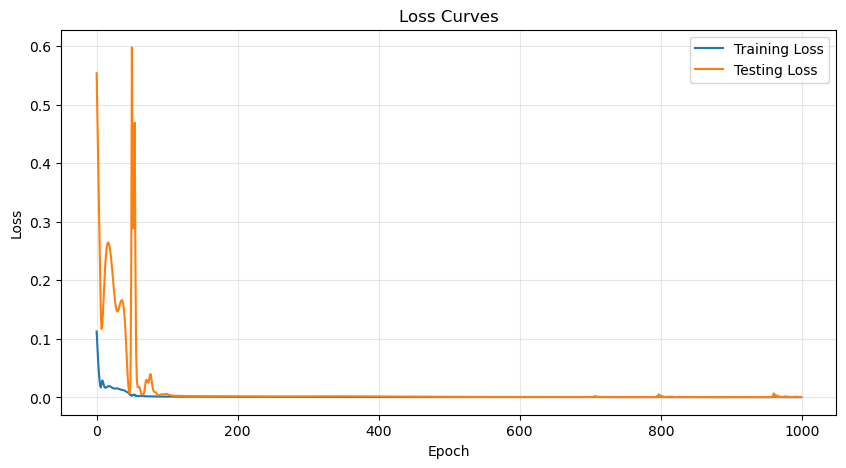

In [ ]:
def main():
    now = datetime.now()
    print('Current time:', now.strftime('%Y-%m-%d %H:%M:%S'))
    print(f"Using device: {config['device']}")
    
    # Loop through all tickers in the config
    for ticker in config['tickers']:
        print(f"\n{'='*50}")
        print(f"Processing {ticker}...")
        print(f"{'='*50}")
        
        try:
            # Step 1: Create dataset and fetch data
            dataset = StockDataset(config)
            stock_data = dataset.fetch_stock_data(ticker)
            
            # Step 2: Preprocess data
            X_train, y_train, X_test, y_test = dataset.preprocess_data()
            
            print(f"Training data shape: {X_train.shape}")
            print(f"Testing data shape: {X_test.shape}")
            
            # Step 3: Create predictor and train model
            predictor = StockPredictor(config)
            predictor.train(X_train, y_train, X_test, y_test)
            
            # Step 4: Make predictions
            train_pred_scaled, test_pred_scaled = predictor.predict(X_train, X_test)
            
            # Step 5: Inverse transform predictions to get actual prices
            train_predictions = dataset.inverse_transform(train_pred_scaled)
            test_predictions = dataset.inverse_transform(test_pred_scaled)
            y_train_actual = dataset.inverse_transform(y_train.cpu().numpy())
            y_test_actual = dataset.inverse_transform(y_test.cpu().numpy())
            
            # Step 6: Get dates for plotting
            train_dates, test_dates = dataset.get_stock_dates_for_plotting(len(y_train), len(y_test))
            
            # Step 7: Predict future prices
            print("\nPredicting future prices...")
            future_input = dataset.prepare_future_prediction_data()
            future_pred_scaled = predictor.predict_future(future_input)
            future_predictions = dataset.inverse_transform(future_pred_scaled)
            
            # Create future dates for visualization
            last_date = stock_data.index[-1]
            future_dates = dataset.create_future_dates(last_date, config['predict_horizon'])
            
            print(f"\nPredicted prices for the next {config['predict_horizon']} trading days:")
            for i, (date, price) in enumerate(zip(future_dates, future_predictions.flatten())):
                print(f"  {date.strftime('%Y-%m-%d')}: ${price:.2f}")
            
            # Step 8: Visualize results with future predictions
            predictor.visualize_results(
                train_dates, test_dates,
                train_predictions, test_predictions,
                y_train_actual, y_test_actual,
                ticker,
                future_dates=future_dates,
                future_pred=future_predictions
            )
            
            # Save the model (optional)
            # predictor.save_model(f"{config['save_path']}model_{ticker}.pth")
            
        except Exception as e:
            print(f"Error processing {ticker}: {str(e)}")
            import traceback
            traceback.print_exc()
            print("")
            print("Suggestions to fix the issue:")
            print("1. If markets have been closed for multiple days, try using a different ticker with more market availability.")
            print("2. Try using a cryptocurrency ticker like 'BTC-USD' which trades every day.")
            print("3. Try using a different date range or reducing the sequence_length.")
            print("4. Check if the ticker symbol is valid.")
            print("5. Try decreasing the data_length parameter if there's not enough historical data available.")
            
            # Continue to the next ticker
            continue

if __name__ == '__main__':
    main()